In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from diffusion_FEM import Diffusion

In [2]:
def material_function(parameters):
    def fun(x):
        val = np.sin(x[:, 0]) + np.sin(x[:, 1])
        res = np.zeros_like(val) + parameters[1]
        res[val < -1.2] = parameters[0]
        res[val > 0.8] = parameters[2]
        return res
    return fun

In [3]:
class Toy_example(Diffusion):
    def __init__(self):
        # problem parameters
        lenght_x, length_y = 10, 10  # domain size
        nx, ny = 100, 100  # number of grid points
        #material = lambda x: np.sin(x[:, 0]) + np.sin(x[:,1]) + 10  # material function
        material = material_function(parameters = np.array([1,200,300]))
        source = 0 #-1  # source term

        # generate mesh
        coords_x, coords_y = np.meshgrid(np.linspace(0, lenght_x, nx), np.linspace(0, length_y, ny))
        coords_x, coords_y = coords_x.ravel(), coords_y.ravel()
        node = np.column_stack((coords_x, coords_y))
        elem = self.rectangle_triangulation(nx, ny)

        # boundary conditions
        side_left = coords_x == 0
        side_right = coords_x == lenght_x
        nodes_Dirichlet = side_left | side_right
        values_Dirichlet = np.zeros((node.shape[0],))
        values_Dirichlet[side_left] = 80
        values_Dirichlet[side_right] = 10
        values_Dirichlet = values_Dirichlet[nodes_Dirichlet]
        
        super().__init__(node=node, elem=elem, nodes_Dirichlet=nodes_Dirichlet, values_Dirichlet=values_Dirichlet, material=material, source=source)

    def rectangle_triangulation(self, nx, ny):
        """Generate triangular elements for a structured rectangular mesh."""
        elements = []
        for j in range(ny - 1):
            for i in range(nx - 1):
                n1 = j * nx + i
                n2 = n1 + 1
                n3 = n1 + nx
                n4 = n3 + 1
                elements.append([n1, n2, n4])  # Upper triangle
                elements.append([n1, n4, n3])  # Lower triangle
        return np.array(elements, dtype=int)


In [4]:
my_diffusion = Toy_example()
my_diffusion.assemble_system()
my_diffusion.solve()
measurement_points = np.where((my_diffusion.coords_y == 0) & ((my_diffusion.coords_x > 4) & (my_diffusion.coords_x<6)))[0]

def forward_model(parameters):
    my_diffusion.change_material(material_function(parameters))
    # my_diffusion.assemble_system()
    my_diffusion.solve()
    return my_diffusion.get_state_function_observations(measurement_points)

print(forward_model([1,200,300]))
print(forward_model([2,150,500]))


[53.32657044 52.43519516 51.54024002 50.64242306 49.74241214 48.84083668
 47.93829871 47.03538334 46.13266877 45.23073613 44.33017932 43.43161519
 42.53569415 41.64311127 40.75461806 39.87103455 38.99326138 38.12229137
 37.25921942 36.40524942]
[55.87379143 54.7031628  53.52355483 52.33691048 51.14497605 49.94934595
 48.75150632 47.55287738 46.35485486 45.158851   43.96633559 42.77887769
 41.59818818 40.4261633  39.26492863 38.11688254 36.98473726 35.87155497
 34.78077478 33.71622532]


/home/simona/GIT/BC/FEM/diffusion_FEM.py:181: UserWarning: The following kwargs were not used by contour: 'triangles'
  contour = plt.tricontourf(self.coords_x, self.coords_y, self.solution, triangles=self.elem, cmap='viridis', levels=50)


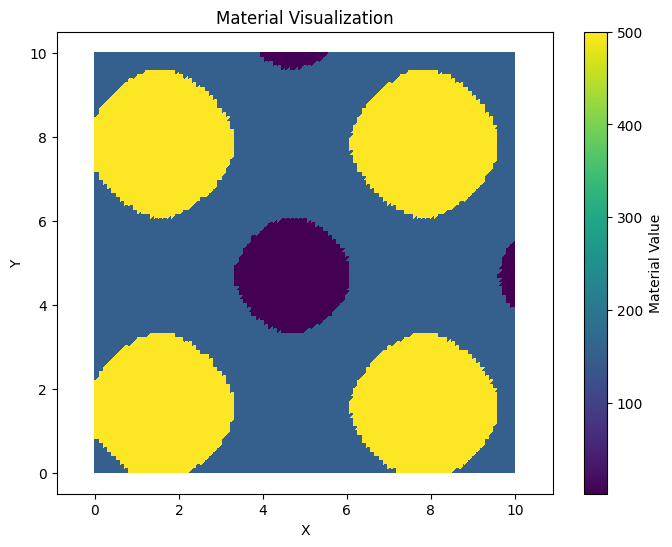

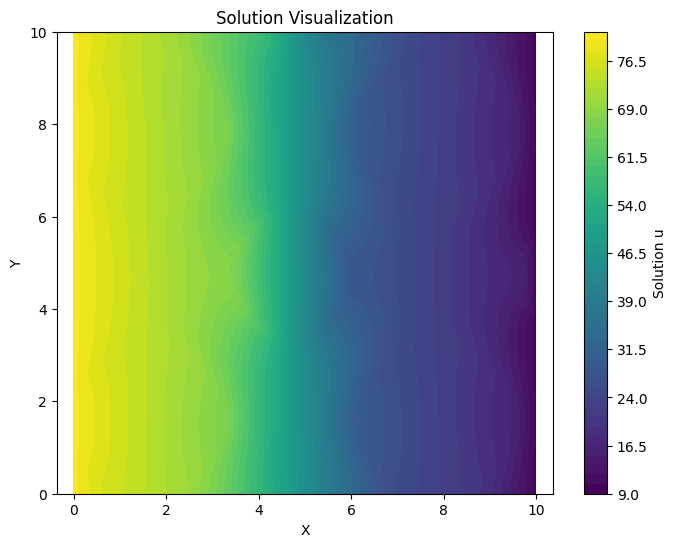

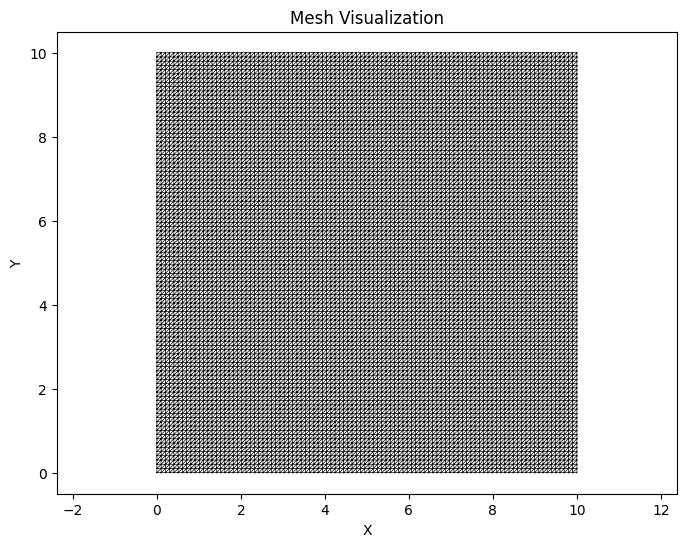

In [5]:
my_diffusion.plot_material()
my_diffusion.plot_state_function()
my_diffusion.plot_mesh()